# Summary of all techniques for stitching thermal drone imagery

## 1 - Data import

In [18]:
# Variable definition
imgDir = 'data/lsm/Flight 1 - Library/thermal-data/' # Directory to images
imageType, cmap = False, 'hot' # True if RGB images, False if numpy arrays
pathFile = 'data/lsm/Flight 1.csv' # Flight path .csv file
utcDiff = -1 # Time difference to UTC (-1 for BST)
pathColumns = ['timestamp','latitude','longitude','altitude(m)','pitch(deg)','roll(deg)','yaw(deg)'] # Columns used from the path file
minAlt, maxAlt, altCol = 119.7, 120.3, 'altitude(m)' # Altitude criteria for using imagery, if wanted else False
imgTimes = [1619811011923,1619811099149] # Specify times if wanted else False
utmZone, hemisphere = '31n', 'north' # Specify UTM coordinate zone
pxSize = 0.27 # Specify pixel size (m) - for now
#resolutions = [2, 6, 60] # Specify output resolutions desired

In [40]:
# Import packages
%pip install imutils opencv-python
import glob
import rasterio as ro
import re
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Proj
from tqdm import tqdm
from scipy.interpolate import griddata
from PIL import Image
from skimage.measure import block_reduce
import cv2
import imageio
import imutils
cv2.ocl.setUseOpenCL(False)

Note: you may need to restart the kernel to use updated packages.


In [10]:
## Get image dataframe with corresponding properties extracted frpm path file
fileTypes = ('.jpg','.png','.tif') if imageType else ('.npy')
imgs = [_ for _ in glob.glob(imgDir+'*.*') if _.endswith(fileTypes)]
imgs.sort()
# Extract date and time from filenames
imgdates = [re.search('/20(.+?)_', path).group(1) for path in imgs] # Extract date from filename
imgtimes = [re.search('_(.+?)_', path).group(1) for path in imgs] # Extract time from filename
# Convert to unix datetime 
imgdatetimes = np.array([(datetime.timestamp(datetime(int('20'+imgdates[i][:2]),int(imgdates[i][2:4]),int(imgdates[i][4:6]),int(imgtimes[i][:2])+utcDiff,int(imgtimes[i][2:4]),int(imgtimes[i][4:6])))) for i in range(len(imgs))])*1000

# Imprt paths and get corresponding timestamps for images
pathDf = pd.read_csv(pathFile)
# Get nearest GPS timestamp
gpstimes = [min(pathDf['timestamp'], key=(lambda list_value : abs(list_value - i))) for i in imgdatetimes]

# Create image dataframe
imgDf = pd.DataFrame(data=np.array([imgs,gpstimes]).transpose(),columns=['imgPath','timestamp'])
imgDf['timestamp'] = imgDf['timestamp'].astype(float)

# Merge with path dataframe
merged = imgDf.merge(pathDf[pathColumns], on='timestamp', how='left')
# Filter for acceptable measurement altitudes
merged = merged.loc[(merged[altCol] > minAlt) & (merged[altCol] < maxAlt)]
if imgTimes: merged = merged.loc[(merged['timestamp'] > imgTimes[0]) & (merged['timestamp'] < imgTimes[1])]

# Convert coordinates to UTM
myProj = Proj('+proj=utm +zone='+utmZone+', +'+hemisphere+' +ellps=WGS84 +datum=WGS84 +units=m +no_defs')
merged['x'], merged['y'] = myProj(merged['longitude'].values, merged['latitude'].values)

# Display example
merged.head()

,imgPath,timestamp,latitude,longitude,altitude(m),pitch(deg),roll(deg),yaw(deg),x,y
51,data/lsm/Flight 1 - Library/thermal-data/20210...,1.619811e+12,52.204650,0.108394,120.0,-11.4,3.7,-91.5,302416.998183,5.787742e+06
52,data/lsm/Flight 1 - Library/thermal-data/20210...,1.619811e+12,52.204648,0.108318,120.1,0.4,4.8,-91.1,302411.797335,5.787742e+06
53,data/lsm/Flight 1 - Library/thermal-data/20210...,1.619811e+12,52.204647,0.108254,120.0,-2.2,4.2,-91.2,302407.420709,5.787742e+06
54,data/lsm/Flight 1 - Library/thermal-data/20210...,1.619811e+12,52.204646,0.108182,120.0,-2.1,5.2,-91.2,302402.497560,5.787742e+06
55,data/lsm/Flight 1 - Library/thermal-data/20210...,1.619811e+12,52.204645,0.108109,120.0,-2.0,4.9,-91.1,302397.506096,5.787742e+06


## 2 - Visualise example data

In [25]:
def img_to_arr(filepath, xq=False, yq=False):
    if '.npy' in filepath: 
        arr = np.load(filepath)
        if xq and yq: arr = arr[yq:3*yq,xq:3*xq]
    else:
        img = ro.open(filepath)
        read = img.read()[:, yq:3*yq,xq:3*xq] if xq and yq else img.read()
        arr = np.dstack((read[0],read[1],read[2]))/255  
    return arr

def downsample_arr(arr, pxsize, resolution):
    ds = int(np.floor(resolution/pxSize))
    if len(arr.shape) == 3:       
        return np.dstack(([block_reduce(arr[:, :, i], (ds, ds), np.mean) for i in range(arr.shape[2])]), axis=-1)
    else: 
        return block_reduce(arr, (ds, ds), np.mean)

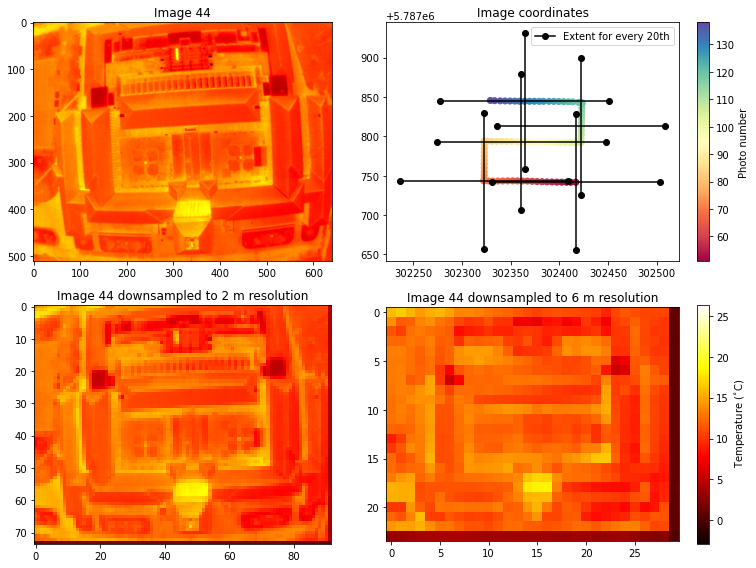

In [33]:
## Plot flight path with an example image and downscale
imageNum = 44 # Example image
resolutions = [2, 6, 60] # Resolutions to downsample to 
skip = 20 # Plot every nth image for path

# Plot example image
fig, axs = plt.subplots(2,2,figsize=[11,8])
arr = img_to_arr(merged.iloc[imageNum]['imgPath'])
a = axs[0,0].imshow(arr, cmap=cmap)
axs[0,0].set_title('Image {}'.format(imageNum))

# Plot route
b = axs[0,1].scatter(merged.x,merged.y,c=merged.index, cmap='Spectral')
size = np.array(arr.shape[:2])*pxSize/2
for i, row in merged[::skip].iterrows():
    axs[0,1].plot([row.x-size[1], row.x+size[1]], [row.y, row.y],'k-o')
    axs[0,1].plot([row.x, row.x],[row.y-size[1], row.y+size[1]],'k-o')
axs[0,1].set_title('Image coordinates')
axs[0,1].legend(labels=['Extent for every {}th'.format(skip)])
fig.colorbar(b, ax=axs[0,1],label='Photo number')

# Plot example downsampled image
for i, val in enumerate(resolutions):
    ds_array = downsample_arr(arr, pxSize, val)
    if i<2:
        c = axs[1,i].imshow(ds_array) if imageType else axs[1,i].imshow(ds_array, vmin=arr.min(), vmax=arr.max(),cmap=cmap)
        axs[1,i].set_title('Image {} downsampled to {} m resolution'.format(str(imageNum),val))
if imageType is False: fig.colorbar(c, ax=axs[1,1], label=' Temperature ($^{\circ}$C)')
fig.tight_layout()
plt.show()

fig.savefig('plots/Image{}.png'.format(str(imageNum)))

In [34]:
fig.savefig('plots/single_thermal.png')

## 3 - OpenCV stitching (2-image example)

Lossy conversion from float64 to uint8. Range [3.095397996290785, 26.016020561399557]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [1.5428183478051096, 27.965781414022103]. Convert image to uint8 prior to saving to suppress this warning.


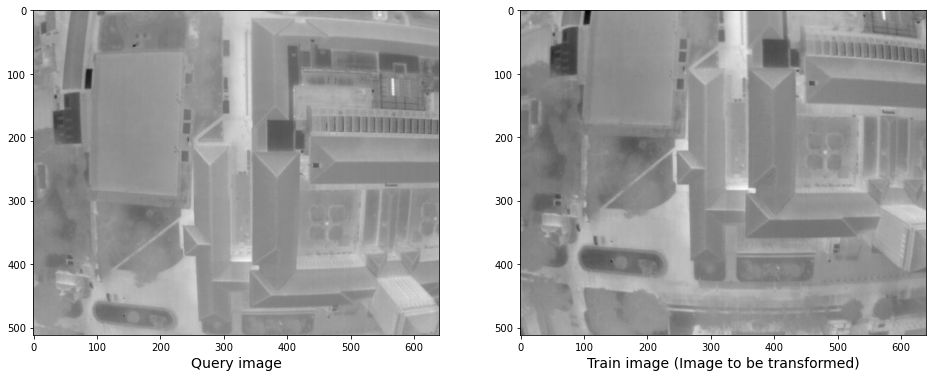

In [84]:
## Visualise images to be stitched
imageNums = [5,10]

# Stitching properties
feature_extractor = 'orb' # one of 'sift', 'surf', 'brisk', 'orb'
feature_matching = 'bf'
arrs = [img_to_arr(merged.iloc[imageNums[0]]['imgPath']),img_to_arr(merged.iloc[imageNums[1]]['imgPath'])]
imageio.imwrite('temp0.jpg',np.dstack((arrs[0],arrs[0],arrs[0])))
imageio.imwrite('temp1.jpg',np.dstack((arrs[1],arrs[1],arrs[1])))
# Read images - Make sure that the train image is the image that will be transformed
trainImg, queryImg = [imageio.imread(i) for i in ['temp0.jpg','temp1.jpg']]
# Opencv defines the color channel in the order BGR - transform it to RGB to be compatible to matplotlib
trainImg_gray, queryImg_gray = [cv2.cvtColor(i, cv2.COLOR_RGB2GRAY) for i in [trainImg, queryImg]]

# Plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(queryImg, cmap="gray"), ax1.set_xlabel("Query image", fontsize=14)
ax2.imshow(trainImg, cmap="gray"), ax2.set_xlabel("Train image (Image to be transformed)", fontsize=14)
plt.show()

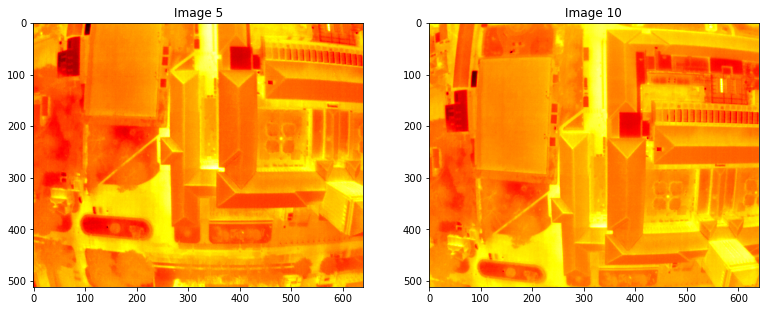

In [41]:
# Plot images to be stitched
imageNums = [5,10]
fig, axs = plt.subplots(1,2,figsize=[13,5])
for i, val in enumerate(imageNums):
    arr = img_to_arr(merged.iloc[val]['imgPath'])
    a = axs[i].imshow(arr,cmap=cmap)
    axs[i].set_title('Image {}'.format(val))

In [85]:
def detectAndDescribe(image, method=None):
    """
    Compute key points and feature descriptors using an specific method
    """
    
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"
    
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)
    
    return (kps, features)

In [86]:
kpsA, featuresA = detectAndDescribe(trainImg_gray, method=feature_extractor)
kpsB, featuresB = detectAndDescribe(queryImg_gray, method=feature_extractor)

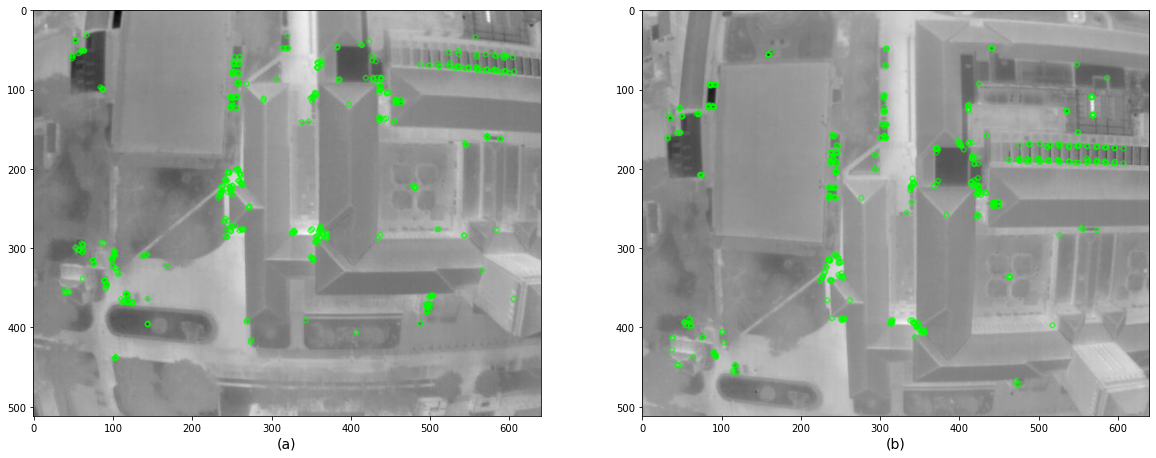

In [87]:
# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(trainImg_gray,kpsA,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(queryImg_gray,kpsB,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

plt.show()

In [88]:
def createMatcher(method,crossCheck):
    "Create and return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

def matchKeyPointsKNN(featuresA, featuresB, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

Using: bf feature matcher
Raw matches (Brute force): 201


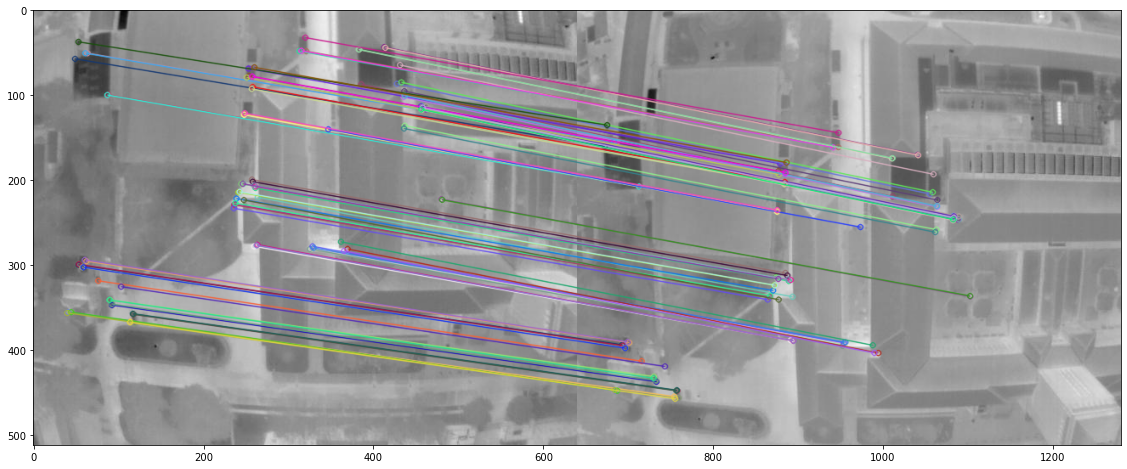

In [89]:
feature_extractor = 'brisk'
feature_matching = 'bf'
print("Using: {} feature matcher".format(feature_matching))

fig = plt.figure(figsize=(20,8))

if feature_matching == 'bf':
    matches = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_matching == 'knn':
    matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    

plt.imshow(img3)
plt.show()

In [90]:
def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None

In [91]:
M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=4)
if M is None:
    print("Error!")
(matches, H, status) = M
print(H)

[[ 1.12302321e+00  1.26867988e-01 -4.06601776e+01]
 [ 1.12812597e-01  1.17956684e+00  8.18937117e+01]
 [ 1.26394608e-04  3.81505211e-04  1.00000000e+00]]


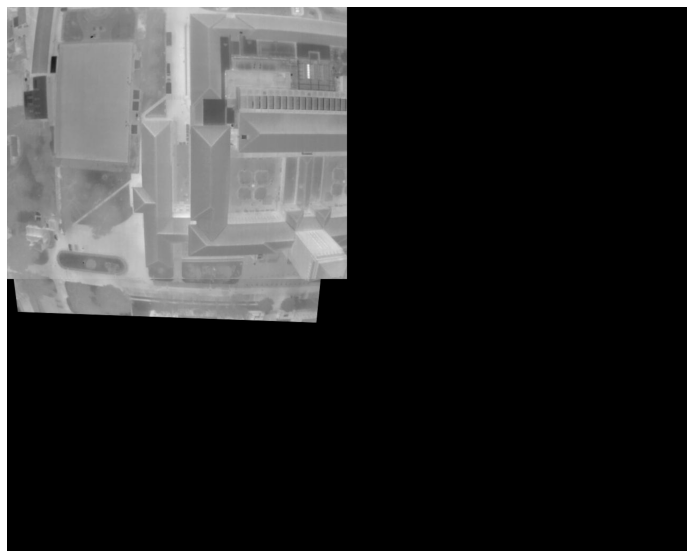

In [92]:
# Apply panorama correction
width = trainImg.shape[1] + queryImg.shape[1]
height = trainImg.shape[0] + queryImg.shape[0]

result = cv2.warpPerspective(trainImg, H, (width, height))
result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

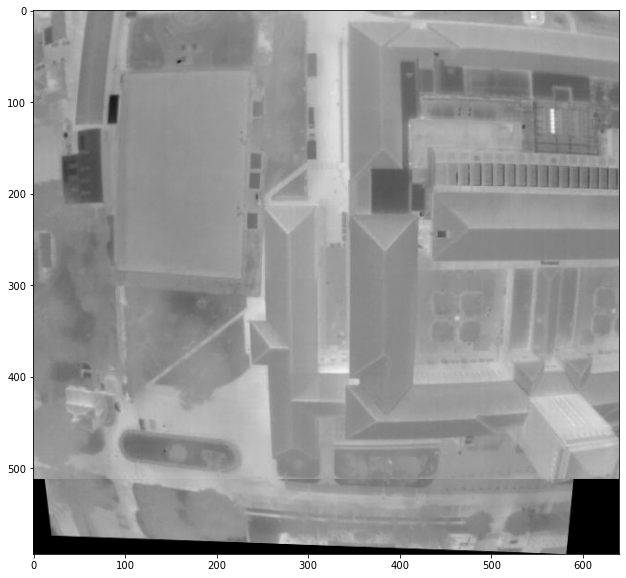

In [93]:
# transform the panorama image to grayscale and threshold it 
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# Finds contours from the binary image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# get the maximum contour area
c = max(cnts, key=cv2.contourArea)

# get a bbox from the contour area
(x, y, w, h) = cv2.boundingRect(c)

# crop the image to the bbox coordinates
result = result[y:y + h, x:x + w]

# show the cropped image
plt.figure(figsize=(20,10))
plt.imshow(result)

In [95]:
image_to_write = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
cv2.imwrite("plots/thermalStitch.png", image_to_write)

True